### Executing for the first time

- 1. Update git submodules 
```
git submodule update --init --recursive
```
- 2. Install necessary python packages with `pip`
```
cd monitoring-ecosystem-resilience
pip install .
```

- 3. `earthengine authenticat`

In [1]:
import sys
import os
sys.path.append("../../sbo")
sys.path.append("monitoring-ecosystem-resilience")

import sys
import matplotlib.pyplot as plt
import numpy as np

import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from pyro.infer import Trace_ELBO

# Import SBO
import sbo
import utilities

# Import pyveg
from pyveg.scripts.optimize_gee_threshold import optimize_threshold

CONST_STDOUT = sys.stdout

## Helper functions

In [2]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = CONST_STDOUT

## Target function

In [3]:
class ThresholdTarget(sbo.TargetFunction):
    
    def eval(self, x):
                
        results = []
        
        no_x = x.shape[0]
                
        for x_i in range(no_x):

            x_int = int(x[x_i].detach().numpy())
            
            blockPrint()
            result_x = optimize_threshold(x_int)
            enablePrint()
            
            results.append(result_x)
                
        return -torch.FloatTensor(results)
    
target = ThresholdTarget([[0, 765]])

## Training data

In [4]:
utilities.set_random_seed(555)

In [5]:
N_train_points = 2

X_train = torch.rand(N_train_points, 1)*765

#y_train = torch.tensor([-0.7107, -0.0000])
y_train = target.eval(X_train)

## Parametric model

In [6]:
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        
        self.beta = PyroSample(dist.Uniform(-100, 100))
        
    def forward(self, X):
        
        middle = 383.0
        X_adjusted = X - middle
        
        result = torch.pow(X_adjusted + self.beta, 2) / middle**2 - 1
              
        return result.squeeze()

## SBO approach

In [7]:
pyro.clear_param_store()

# SBO parameters
sbo_steps = 11

opti_num_steps = 100
opti_params = {"lr": 0.1}
optimizer = pyro.optim.Adam(opti_params)
loss = Trace_ELBO()

return_site = "EI"

# Acquisition function optimizer
acqf_optimizer = torch.optim.Adam
acqf_opti_num_steps = 100
acqf_opti_lr = 0.5

num_candidates = 10

# Sampling
num_samples = 5

# GP kernel
kernel = gp.kernels.Matern52(
    input_dim = X_train.shape[1], lengthscale = 100*torch.ones(X_train.shape[1]))

# Semi paramteric GP model
model = sbo.SemiParametricModel(X_train, y_train, ParametricMeanFn(), kernel)

# Defining GP's parameters
model.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 100).expand([X_train.shape[1]]).to_event())
model.gp.kernel.variance = PyroSample(dist.Uniform(0, 50))
model.gp.noise = PyroSample(dist.Uniform(0, 1))

guide = None
xmins = np.zeros([sbo_steps, 2], np.float32)


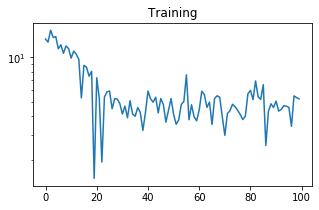

SBO   step: 0 tensor([346.8587]) tensor(-0.)


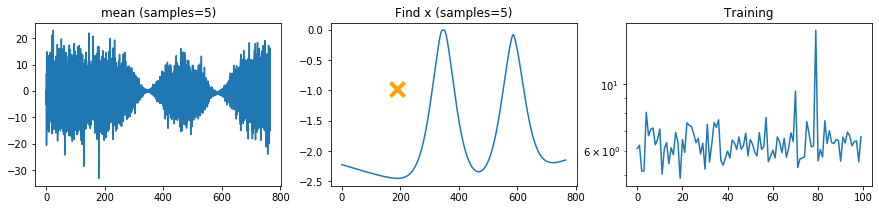

SBO   step: 1 tensor([188.3226]) tensor(-0.9773)


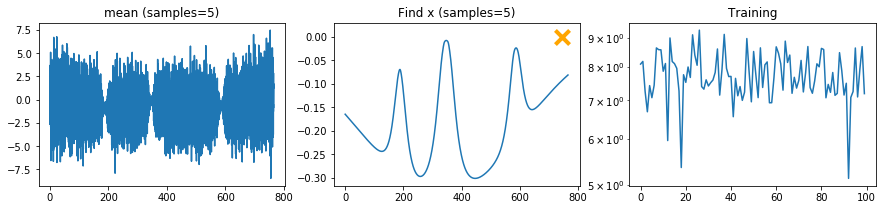

SBO   step: 2 tensor([744.2615]) tensor(-0.)


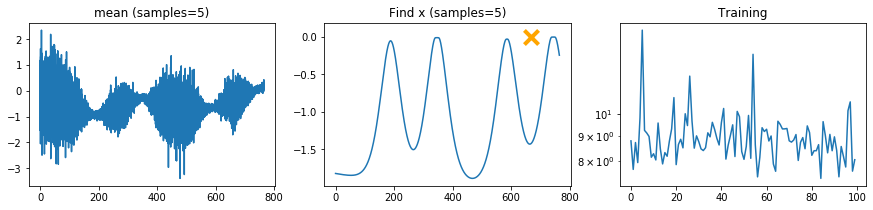

SBO   step: 3 tensor([667.3684]) tensor(-0.)


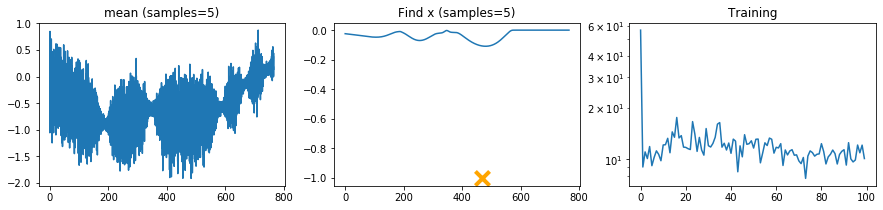

SBO   step: 4 tensor([467.3198]) tensor(-1.)


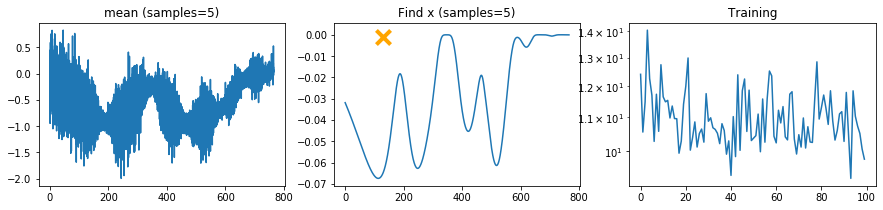

SBO   step: 5 tensor([130.5204]) tensor(-0.0010)


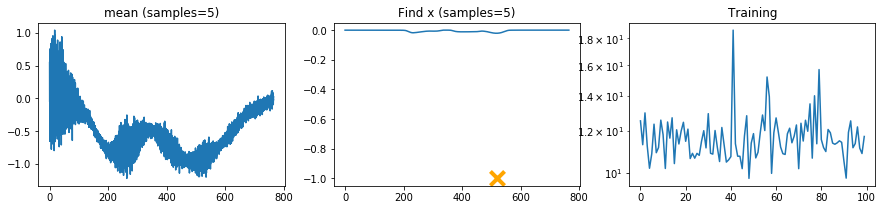

SBO   step: 6 tensor([519.8555]) tensor(-0.9990)


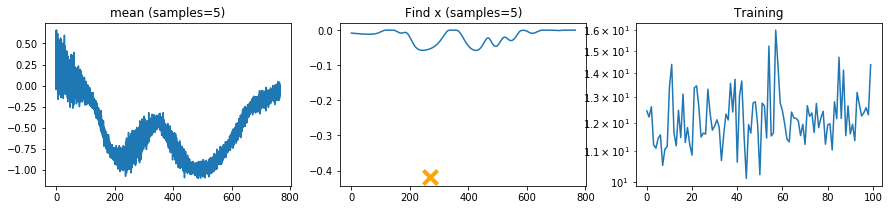

SBO   step: 7 tensor([267.5689]) tensor(-0.4194)


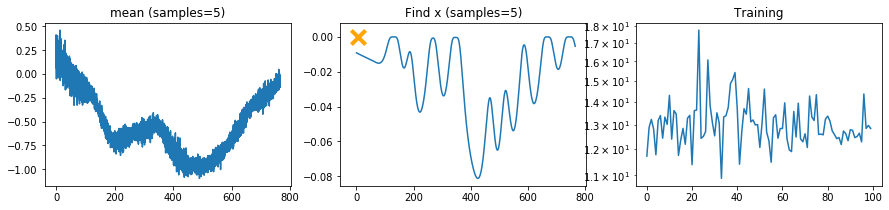

SBO   step: 8 tensor([6.5071]) tensor(-0.)


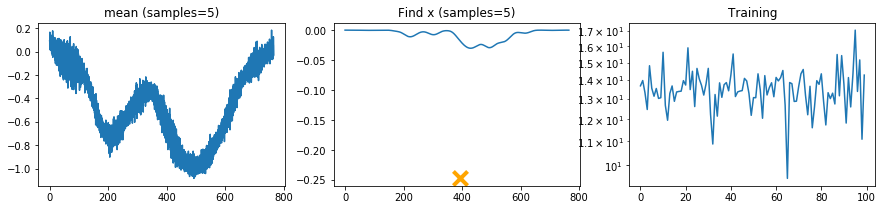

SBO   step: 9 tensor([394.4815]) tensor(-0.2459)


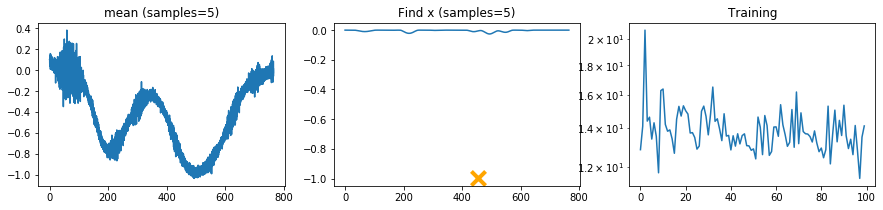

SBO   step: 10 tensor([454.3394]) tensor(-0.9979)


In [8]:
for i in range(sbo_steps):

    guide, predict, losses = sbo.step(model, guide, optimizer, loss, target, acqf_optimizer, 
                                      opti_num_steps=opti_num_steps, acqf_opti_num_steps=acqf_opti_num_steps,
                                      acqf_opti_lr=acqf_opti_lr, num_samples=num_samples, 
                                      num_candidates=num_candidates,
                                      return_site=return_site)
    
    ######################
    # Visualising the step
    ######################
    steps = 10000
    x_values = torch.linspace(target.ranges[0][0], target.ranges[0][1], 
                              steps).unsqueeze(dim=1)

    if i == 0:
        plt.figure(figsize=(5, 3))
        
        plt.title("Training")
        plt.semilogy(losses)
        
    else:
        plt.figure(figsize=(15, 3))

        plt.subplot(1,3,1)
        plt.title("mean (samples=%d)" % (num_samples))

        with torch.no_grad():
            y_values = predict(x_values)["y"].mean(0).detach().numpy()
            plt.plot(x_values, y_values)

        plt.subplot(1,3,2)
        plt.title("Find x (samples=%d)" % (num_samples))

        with torch.no_grad():
            ei_values = predict(x_values)["EI"].mean(0).detach().numpy()
            plt.plot(x_values, ei_values)

        plt.scatter(model.X[-1, 0].detach().numpy(), model.y[-1].detach().numpy(), 
           marker="x", s=200, c='orange', zorder=2, linewidth=4);

        plt.subplot(1,3,3)
        plt.title("Training")
        plt.semilogy(losses);

    plt.show()
    
    print("SBO   step: %d" % (i), model.X[-1], model.y[-1])


## Plotting averaged GP mean

In [9]:
results_loaded = np.loadtxt("thresholds.out", delimiter=',')

In [10]:
import copy
predict = pyro.infer.Predictive(copy.copy(model), guide=guide,
                                num_samples=num_samples, return_sites=('y', return_site))

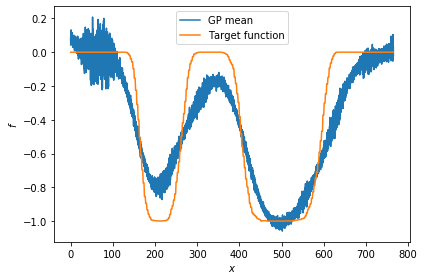

In [19]:
with torch.no_grad():
    y_values = predict(x_values)["y"].mean(0).detach().numpy()
    
    plt.plot(x_values, y_values, label='GP mean')
    
    plt.plot(results_loaded[:, 0], -1.0*results_loaded[:, 1], label='Target function')
    
    plt.xlabel('$x$')
    plt.ylabel('$f$')
    plt.tight_layout()
    
    plt.legend();
    
    plt.savefig('GP_mean_target.png', dpi=300)
    